# Robust Controlled Trials

The Randomized Controlled Trial (RCT) is a trusted method in experimental design that aims to figure out responses to certain interventions, while reducing the discrepancy in results due to variance in subjects. In fact, in 2019, Prof. Duflo and Banerjee from MIT got the Nobel Prize in Economics for addressing questions/issues in development economics (esp. poverty and availability of healthcare) using RCTs. 

But very few people talked about the fact that RCTs are quite ineffective in one major aspect: They rely on the Central Limit Theorem to ensure that control and experiments have similar inter-group and intra-group distributions of traits. This requires large experimental populations, which are expensive and often unavailable. 

Instead, there is research to suggest that **optimal controlled trials** can be significantly more powerful. 

This demo will hopefully demonstrate that randomization is NOT a reliable method for getting the right distribution of "features" in subjects. Furthermore, it will demonstrate the influence of robustness on optimal experimental design. 

## Motivational Problem: Medical Trials

Suppose that we only have the budget to conduct initial Covid-19 vaccine trials on 20 patients, where the patients are split 50/50 between control and treatment groups. We have had 30 applicants with 5 traits, generated randomly in this instance. (We have chosen small numbers since this problem can quickly become computationally challenging. But it is definitely solvable in larger scale as well.)

First, we initialize our computational environment.

In [ ]:
# Activating Julia environment
using Pkg
Pkg.activate(".")
using JuMP, Distributions, Random, LinearAlgebra, GLPK, PyPlot
const plt = PyPlot

Then, we generate some random patients, with traits being sampled from the standard normal. 

In [ ]:
function generate_random_people(n_people::Int64 = 20, n_traits::Int64 = 5)
    # NOTE THAT OUR DATA IS NORMALIZED, so it makes the formulation more straight-forward. 
    continuous_values = rand(MersenneTwister(314), Normal(0.00, 1), (n_people, n_traits))
    return continuous_values
end
n_groups = 2
n_patients = 20
n_ppg = n_patients/n_groups
n_people = 30
n_traits = 5
data = generate_random_people(n_people, n_traits)
target_means = vec(sum(data[:, :], dims=1)/n_people)
target_variances = vec(sum(data[:, :].^2, dims=1)/n_people)

In [ ]:
""" Function to compute the elementwise maximum. Will be useful later! """
function elem_maximum(a...)
    na = []
    for i = 1:length(a[1])
        push!(na, maximum([elem[i] for elem in a]))
    end
    return na
end

Initially, we will create our control and experiment groups by simply picking the first 10 to be in the control, and the next 10 to be in the experiment groups. Then, we can evaluate the means and variances of the traits of patients in each group, and compare them. 
(For simplicity, we will only consider the diagonal of the covariance matrix. However, this method can be extended to the full covariance matrix, by adding a lot more variables!)

In [ ]:
# Experimental design through randomization
ctrl_idxs = Int64.(collect(1:n_patients/2))
vacc_idxs = Int64.(collect(n_patients/2+1:n_patients))
function print_details(data, ctrl_idxs, vacc_idxs)
    println("Control group: ", ctrl_idxs)
    println("Vaccine group: ", vacc_idxs)
    println("Mean traits of control group: ", round.(mean(data[ctrl_idxs, :], dims=1); sigdigits = 4))
    println("Mean traits of vaccine group: ", round.(mean(data[vacc_idxs, :], dims=1); sigdigits = 4))
    println("Var of traits of control group: ", round.(var(data[ctrl_idxs, :], dims=1); sigdigits = 4))
    println("Var of traits of vaccine group: ", round.(var(data[vacc_idxs, :], dims=1); sigdigits = 4))
    mean_errors = abs.(mean(data[ctrl_idxs, :], dims=1)' - mean(data[vacc_idxs, :], dims=1)')
    println("Nominal objective: ", round(
        sum(elem_maximum(abs.(mean(data[ctrl_idxs, :], dims=1)' .- target_means),
                         abs.(mean(data[vacc_idxs, :], dims=1)' .- target_means))) + 
        0.5*sum(elem_maximum(abs.(var(data[ctrl_idxs, :], dims=1)' - var(data[vacc_idxs, :], dims=1)'),
                             abs.(var(data[ctrl_idxs, :], dims=1)' .- target_variances))); sigdigits = 4))
    return
end
print_details(data, ctrl_idxs, vacc_idxs)

We will describe the objective function in greater detail later, but we can think about it as some sum of errors between the means and variances of the experiment and control groups. 

We can examine these errors more specifically by plotting them.

In [ ]:
function plot_errors(data, ctrl_idxs, vacc_idxs)
    plt.subplot(1,3,1)
    plt.bar(1:5, vec(sum(data[ctrl_idxs, :], dims=1)/n_ppg .-  sum(data[vacc_idxs, :], dims=1)/n_ppg))
    plt.xlabel("Features")
    plt.ylabel("Intra-group mean error")
    plt.ylim((0.8, -0.8))
    plt.subplot(1,3,2)
    plt.bar(1:5, vec(sum(data[ctrl_idxs, :], dims=1)/n_ppg) - vec(sum(data[:, :], dims=1)/n_people))
    plt.xlabel("Features")
    plt.ylabel("Control group mean error w.r.t. population")
    plt.ylim((0.8, -0.8))
    plt.subplot(1,3,3)
    plt.bar(1:5, vec(sum(data[vacc_idxs, :], dims=1)/n_ppg) - vec(sum(data[:, :], dims=1)/n_people))
    plt.xlabel("Features")
    plt.ylabel("Control group mean error w.r.t. population")
    plt.ylim((0.8, -0.8))
    plt.subplots_adjust(hspace = 0.25)
end
plot_errors(data, ctrl_idxs, vacc_idxs)

Clearly, there are some discrepancies between the means and variances of the groups.

### Can Optimization do better? 
It sure can! In this case, we will pick 2 groups of equal numbers of patients from the population, while minimizing some notion of error between the moments of traits in the two populations. 

To begin, we are going to define some target means $\bar{\mu}_j$ and variances $\bar{\sigma}_j$. For this toy example, we are going to assume that our target mean is the whole population mean, and the target variance is the whole population variance. (In theory, we can aim to achieve any target mean and variance we would like, for any number of groups.)

Then we are going to define new variables $M_j$ and $V_j$, where $j$ is the trait index. These will define the maximum of inter-population and intra-group mean and variance errors as follows. 

$M_j = \rm{max}\Big(|\mu_{j,1} - \mu_{j,2}|, |\mu_{j,1} - \bar{\mu}_j|, |\mu_{j,2} - \bar{\mu}_j||\Big),$

$V_j = \rm{max}\Big(|\sigma_{j,1} - \sigma_{j,2}|, |\sigma_{j,1} - \bar{\sigma}_j|, |\sigma_{j,2} - \bar{\sigma}_j||\Big).$

The **intra-group** error is the differences in the values between the experiment and control groups. The **inter-population** error is the difference between the values between each group and the population as a whole. 

Our objective function will be a mixture of these two errors:

Objective function $= \sum M_j + 0.5\sum V_j$

Note that we are not limited to this objective function. (For example, we could try minimizing variance while keeping the mean variation below a threshold... we can try any combination that is bounded!)

This way, the groups will look like each other and like the entire population as much as possible. Let's actually solve this representation of the problem. 

In [ ]:
# Let's start creating out model, and trying to solve without uncertainty
m = Model(GLPK.Optimizer)
set_optimizer_attribute(m, "tm_lim", 60 * 1_000)
set_optimizer_attribute(m, "msg_lev", GLPK.GLP_MSG_ON)
@variable(m, x[i=1:n_people, 1:n_groups], Bin)
@variable(m, μ_p[i=1:n_groups, j=1:n_traits]) # Mean
@variable(m, σ_p[i=1:n_groups, j=1:n_traits]) # Variance
for j = 1:n_groups # Taking the mean and std deviation of parameters for each group
    @constraint(m, μ_p[j,:] .== 1/(n_ppg) * 
                    sum(data[i,:] .* x[i,j] for i=1:n_people))
    @constraint(m, σ_p[j,:] .== 1/(n_ppg) * 
                    sum(data[i,:].^2 .* x[i,j] for i=1:n_people))
    @constraint(m, sum(x[:,j]) == n_ppg)
end
for i = 1:n_people
    @constraint(m, sum(x[i, :]) <= 1) # each patient only picked at most once
end

@variable(m, d)
@variable(m, M[1:n_traits]) # mean error
@variable(m, V[1:n_traits]) # variance error
rho = 0.5
@objective(m, Min, sum(M) + rho*sum(V))
for i = 1:n_groups
    for j = i+1:n_groups
        @constraint(m, M[:] .>= μ_p[i,:] - target_means)
        @constraint(m, M[:] .>= -(μ_p[i,:] - target_means))
        @constraint(m, M[:] .>= μ_p[j,:] - target_means)
        @constraint(m, M[:] .>= -(μ_p[j,:] - target_means))
        @constraint(m, M[:] .>= μ_p[i,:] - μ_p[j,:])
        @constraint(m, M[:] .>= -(μ_p[i,:] - μ_p[j,:]))
        @constraint(m, V[:] .>= σ_p[i, :] - target_variances)
        @constraint(m, V[:] .>= -(σ_p[i, :] - target_variances))
        @constraint(m, V[:] .>= σ_p[j, :] - target_variances)
        @constraint(m, V[:] .>= -(σ_p[j, :] - target_variances))
        @constraint(m, V[:] .>= σ_p[i, :] - σ_p[j,:])
        @constraint(m, V[:] .>= -(σ_p[i, :] - σ_p[j,:]))
    end
end
optimize!(m)

Let's see the results, and how our patients (by index) have changed compared to randomization.

In [ ]:
# Results
ctrl_opt = findall(x -> x == 1, Array(value.(x[:,1])))
vacc_opt = findall(x -> x == 1, Array(value.(x[:,2])))
print_details(data, ctrl_opt, vacc_opt)

We see a  7x improvement in the objective function! We can also see the reduction in mean and variance errors graphically. 

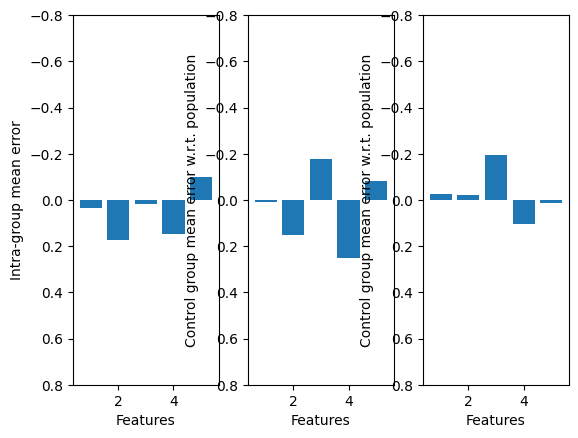

In [11]:
# Plotting the distribution of errors
plot_errors(data, ctrl_opt, vacc_opt)

What this means is that optimization dramatically improves on the quality of the experiment and control groups generated via randomization. It can thus improve the ability of experiments to have significant results, and can allow us to reduce the number of subjects we require to obtain that significance. 

### How does Robust Optimization (RO) change our solutions? 
It is very possible that there is some error in the values of the traits of each subject. These errors could arise from a variety of sources: measurement error, observer's paradox, or even due to subjects lying in order to influence their perceived likelihood of being in the treatment group!

We will deal with this kind of uncertainty through **robust OCTs**. Robust OCT will assume that there is uncertainty in the data in the problem that is defined by an uncertainty set. One potential description of the uncertainty is a **budget uncertainty set**, where the maximum absolute deviation of each trait for each subject is constrained ($||\mathbf{z}||_{\infty} \leq \rho$), as well as the cumulative absolute deviations of each trait for all subjects ($||\mathbf{z}||_{1} \leq \Gamma$). In this case, we assume such an uncertainty set, with an maximum absolute deviation $\rho = 1$, and a cumulative deviation $\Gamma = 2$. Intuitively, this would allow up to 20 trait perturbations of magnitude 0.1, or 40 perturbations of magnitude 0.05, and so on. 

We start our optimization model similarly, by defining the means and variances, as well as the objective function. 

In [31]:
# Let's start creating out model, and trying to solve with uncertainty
rm = Model(GLPK.Optimizer)
set_optimizer_attribute(m, "tm_lim", 60 * 1_000)
set_optimizer_attribute(m, "msg_lev", GLPK.GLP_MSG_ON)
@variable(rm, x[i=1:n_people, 1:n_groups], Bin)
@variable(rm, μ_p[i=1:n_groups, j=1:n_traits]) # Mean
@variable(rm, σ_p[i=1:n_groups, j=1:n_traits]) # Variance
ρ = 0.1
Γ = 2
for j = 1:n_groups # Taking the mean and std deviation of parameters for each group
    @constraint(rm, μ_p[j,:] .== 1/n_ppg * 
                    sum(data[i,:].*x[i,j] for i=1:n_people))
    @constraint(rm, σ_p[j,:] .== 1/n_ppg * 
                    sum(data[i,:].^2 .* x[i,j] for i=1:n_people))
    @constraint(rm, sum(x[:,j]) == n_ppg)
end
for i = 1:n_people
    @constraint(rm, sum(x[i, :]) <= 1)
end
@variable(rm, M[1:n_traits])
@variable(rm, V[1:n_traits])
@objective(rm, Min, sum(M) + 0.5*sum(V))

M[1] + M[2] + M[3] + M[4] + M[5] + 0.5 V[1] + 0.5 V[2] + 0.5 V[3] + 0.5 V[4] + 0.5 V[5]


Note that we have defined some variables $\mathbf{M}$ and $\mathbf{V}$ to describe the errors. We cannot directly embed the uncertainty into means $\mu$ and variances $\sigma$, because these are defined by linear inequalities. Adding robustness to equalities would make this problem infeasible. Instead, we will minimize the **worst-case** errors as described by $\mathbf{M}$ and $\mathbf{V}$, by embedding the budget uncertainty set into the model through its robust counterpart. 

In [32]:
# With the following budget uncertainty
# @uncertain(rm, ell[1:n_people, 1:n_traits])
# @constraint(rm, norm(ell, 1) <= Γ)
# @constraint(rm, -ρ .<= ell .<= ρ)  
# Let's use the robust counterpart
# FIRST, THE ROBUST COUNTERPART FOR THE INTRA-GROUP ERRORS.
for g1 = 1:n_groups-1
    for g2 = g1+1:n_groups
        for l = 1:n_traits
            y = @variable(rm, [1:n_people, 1:n_traits])
            normdummy = @variable(rm, [1:n_people, 1:n_traits])
            @constraint(rm, normdummy .>= y)
            @constraint(rm, normdummy .>= -y)
            infdummy = @variable(rm)
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (x[i,g1] - x[i,g1] - y[i,k]))
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(x[i,g1] - x[i,g1] - y[i,k]))
            @constraint(rm, M[l] * n_ppg >= 
                        sum(data[k,l] .* (x[k,g1] - x[k,g2]) for k=1:n_people) + 
                        ρ * sum(normdummy) + Γ*infdummy)
            y = @variable(rm, [1:n_people, 1:n_traits])
            normdummy = @variable(rm, [1:n_people, 1:n_traits])
            @constraint(rm, normdummy .>= y)
            @constraint(rm, normdummy .>= -y)
            infdummy = @variable(rm)
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (x[i,g1] - x[i,g1] - y[i,k]))
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(x[i,g1] - x[i,g1] - y[i,k]))
            @constraint(rm, M[l] * n_ppg >= 
                        -(sum(data[k,l] .* (x[k,g1] - x[k,g2]) for k=1:n_people)) + 
                        ρ * sum(normdummy) + Γ*infdummy)
            # Sometimes you have to get creative... linearization of the change of the variance. 
            y = @variable(rm, [1:n_people, 1:n_traits])
            normdummy = @variable(rm, [1:n_people, 1:n_traits])
            @constraint(rm, normdummy .>= y)
            @constraint(rm, normdummy .>= -y)
            infdummy = @variable(rm)
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (2*data[i,k]*(x[i,g1] - x[i,g2]) - y[i,k]))
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(2*data[i,k]*(x[i,g1] - x[i,g2]) - y[i,k]))
            @constraint(rm, V[l] * n_ppg >= 
                        sum(data[k,l].^2 .* (x[k,g1] - x[k,g2]) for k=1:n_people) + 
                        ρ*sum(normdummy) + Γ*infdummy)
            y = @variable(rm, [1:n_people, 1:n_traits])
            normdummy = @variable(rm, [1:n_people, 1:n_traits])
            @constraint(rm, normdummy .>= y)
            @constraint(rm, normdummy .>= -y)
            infdummy = @variable(rm)
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (2*data[i,k]*(x[i,g1] - x[i,g2]) - y[i,k]))
            @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(2*data[i,k]*(x[i,g1] - x[i,g2]) - y[i,k]))
            @constraint(rm, V[l] * n_ppg >= 
                        -(sum(data[k,l].^2 .* (x[k,g1] - x[k,g2]) for k=1:n_people)) + 
                        ρ*sum(normdummy) + Γ*infdummy)
        end
    end
end
# THEN, THE ROBUST COUNTERPART FOR THE INTER_POPULATION ERRORS
for g1 = 1:n_groups
    for l = 1:n_traits
        y = @variable(rm, [1:n_people, 1:n_traits])
        normdummy = @variable(rm, [1:n_people, 1:n_traits])
        @constraint(rm, normdummy .>= y)
        @constraint(rm, normdummy .>= -y)
        infdummy = @variable(rm)
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (x[i,g1] - y[i,k]))
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(x[i,g1] - y[i,k]))
        @constraint(rm, M[l] * n_ppg >= 
                    sum(data[k,l] .* x[k,g1] for k=1:n_people) - target_means[l] * n_ppg +
                    ρ * sum(normdummy) + Γ*infdummy)
        y = @variable(rm, [1:n_people, 1:n_traits])
        normdummy = @variable(rm, [1:n_people, 1:n_traits])
        @constraint(rm, normdummy .>= y)
        @constraint(rm, normdummy .>= -y)
        infdummy = @variable(rm)
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (x[i,g1] - y[i,k]))
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(x[i,g1] - y[i,k]))
        @constraint(rm, M[l] * n_ppg >= 
                    -(sum(data[k,l] .* x[k,g1] for k=1:n_people) - target_means[l] * n_ppg) +
                    ρ * sum(normdummy) + Γ*infdummy)
        # Now for the variance
        y = @variable(rm, [1:n_people, 1:n_traits])
        normdummy = @variable(rm, [1:n_people, 1:n_traits])
        @constraint(rm, normdummy .>= y)
        @constraint(rm, normdummy .>= -y)
        infdummy = @variable(rm)
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (2*data[i,k]*(x[i,g1]) - y[i,k]))
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(2*data[i,k]*(x[i,g1]) - y[i,k]))
        @constraint(rm, V[l] * n_ppg >= 
                    sum(data[k,l].^2 .* x[k,g1] for k=1:n_people) - target_variances[l] * n_ppg + 
                    ρ*sum(normdummy) + Γ*infdummy)
        y = @variable(rm, [1:n_people, 1:n_traits])
        normdummy = @variable(rm, [1:n_people, 1:n_traits])
        @constraint(rm, normdummy .>= y)
        @constraint(rm, normdummy .>= -y)
        infdummy = @variable(rm)
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= (2*data[i,k]*(x[i,g1]) - y[i,k]))
        @constraint(rm, [i = 1:n_people, k = 1:n_traits], infdummy >= -(2*data[i,k]*(x[i,g1]) - y[i,k]))
        @constraint(rm, V[l] * n_ppg >= 
                    -(sum(data[k,l].^2 .* x[k,g1] for k=1:n_people) - target_variances[l] * n_ppg) + 
                    ρ*sum(normdummy) + Γ*infdummy)
    end
end

In [ ]:
optimize!(rm)

It seems like we have found a design of experiments that is robust to the budget uncertainty set! Let's take a look at the results. 

In [30]:
ctrl_ro = findall(x -> x >= 0.8, Array(value.(x[:,1])))
vacc_ro = findall(x -> x >= 0.8, Array(value.(x[:,2])))
print_details(data, ctrl_ro, vacc_ro)
println("Robust worst-case objective: ", objective_value(rm))

Control group: Int64[]
Vaccine group: Int64[]
Mean traits of control group: [NaN NaN NaN NaN NaN]
Mean traits of vaccine group: [NaN NaN NaN NaN NaN]
Var of traits of control group: [NaN NaN NaN NaN NaN]
Var of traits of vaccine group: [NaN NaN NaN NaN NaN]
Nominal objective: NaN
Robust worst-case objective: 0.913358627789511


We observe slight changes in the optimal allocations of patients. In addition, the nominal objective is worsened by around 80\% under robustness considerations. However, in presence of uncertainty, this new experimental design makes sure that the worst case outcome of our objective function is only around 25\% worse than the nominal case. The OED without robustness is a lot more sensitive to this uncertainty. Below, we compute the worst-case objective of the random, optimal and robust cases for comparison. 

In [ ]:
# Nominal worst case
constrs = [@constraint(rm, x[ctrl_idxs,1] .== ones(n_ppg))..., @constraint(rm, x[vacc_idxs, 2] .== ones(n_ppg))...]
optimize!(rm)
nom_worst = objective_value(rm);
println("Random worst-case: " * string(nom_worst))
delete.(rm, constrs);
constrs = [@constraint(rm, x[ctrl_opt,1] .== ones(n_ppg))..., @constraint(rm, x[vacc_opt, 2] .== ones(n_ppg))...]
optimize!(rm)
opt_worst = objective_value(rm)
println("Optimal worst-case: " * string(opt_worst))
delete.(rm, constrs);
constrs = [@constraint(rm, x[ctrl_ro,1] .== ones(n_ppg))..., @constraint(rm, x[vacc_ro, 2] .== ones(n_ppg))...]
optimize!(rm)
ro_worst = objective_value(rm)
println("Robust optimal worst-case: " * string(ro_worst))


LoadError: Expected rm to be a JuMP model, but it has type typeof(rm)

What we see is that the robust optimal solution definitively has the lowest worst-case objective, and while the optimal solution (without uncertainty) has a better nominal outcome, it is a lot more sensitive to uncertainties in the traits of the subjects. The randomized cases is again by far the worst, having the worst performance both without and with uncertainty. 

For curiosity's sake, we also plot the mean and variance errors for the robust solution. 

In [ ]:
plot_errors(data, ctrl_ro, vacc_ro)

LoadError: UndefVarError: plot_errors not defined

# Conclusions

- Optimal experimental design is a useful method to make sure that the moments of our experiment and control groups are similar, while still being representative of the global population. 
- Uncertainty can result from a variety of factors in experimental designs. 
- Robust optimal experimental design can improve the efficacy of experiments with small reduction in nominal performance compared to optimized groups without uncertainty. However, robust OED gives significantly better worst-case outcomes, and reduces the sensitivity of experiments to uncertainty in the traits of control and experiment subjects!
- Randomization is consistently the **worst** method for experimental design by far!